In [ ]:
#Importing the necessary libraries
import torch
import os
from torch import nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor
from torchvision.transforms import transforms
from torchvision.datasets import FashionMNIST

%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

In [ ]:
#Importing the data

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5),(0.5))
])

train_dataset = FashionMNIST(root='data', train=True, download=True,
                             transform=transform)
train_loader = DataLoader(train_dataset, batch_size = 64, shuffle = True)

test_dataset = FashionMNIST(root='data',train=False,download=True,
                            transform=transform)
test_loader = DataLoader(test_dataset, batch_size=64,shuffle=True)

100%|██████████| 26421880/26421880 [00:02<00:00, 11820711.97it/s]


Extracting data/FashionMNIST/raw/train-images-idx3-ubyte.gz to data/FashionMNIST/raw



100%|██████████| 29515/29515 [00:00<00:00, 200729.14it/s]


Extracting data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to data/FashionMNIST/raw



100%|██████████| 4422102/4422102 [00:01<00:00, 3762388.83it/s]


Extracting data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to data/FashionMNIST/raw



100%|██████████| 5148/5148 [00:00<00:00, 5821589.91it/s]

Extracting data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to data/FashionMNIST/raw



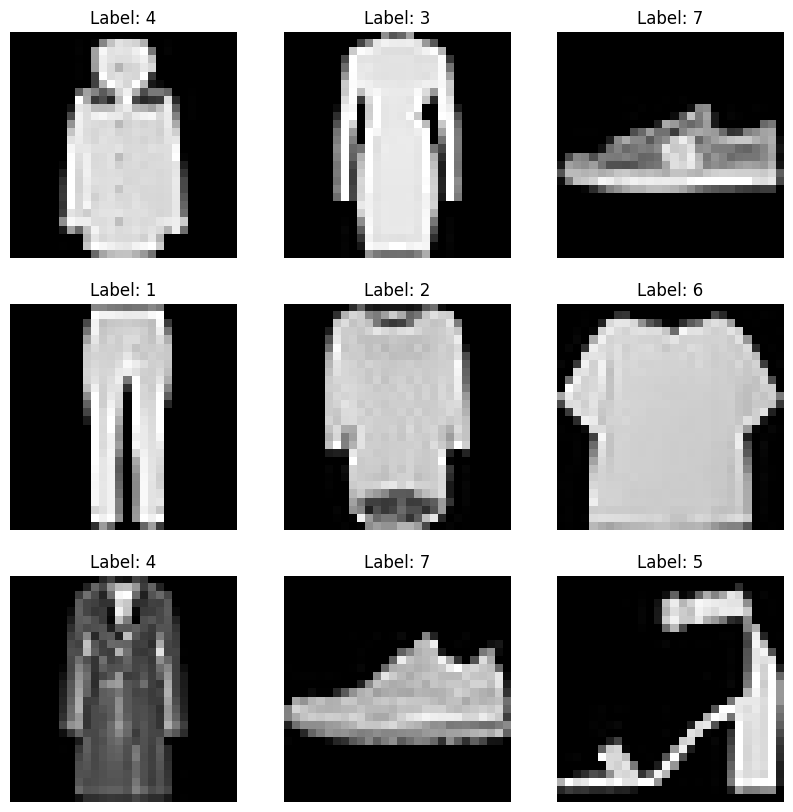

In [ ]:
#Mapping the labels

labels_map = {
    0: 'T-shirts',
    1: 'Trouser',
    2: 'Pullover',
    3: 'Dress',
    4: 'Coat',
    5: 'Sandal',
    6: 'Shirt',
    7: 'Sneaker',
    8: 'Bag',
    9: 'Aankle Boot',
}

figure = plt.figure(figsize=(10, 10))
cols, rows = 3,3

for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(train_dataset), size=(1,)).item()
    image, label = train_dataset[sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.imshow(image.squeeze(), cmap="gray")
    plt.title(f"Label: {label}")
    plt.axis("off")

plt.show()

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f'Using {device} device')

class NeuralNetwork(nn.Module):
  def __init__(self):
    super(NeuralNetwork, self).__init__()

    self.layer1 = nn.Sequential(
        nn.Conv2d(1,96,kernel_size = 11,stride=4,padding=0),
        nn.BatchNorm2d(96),
        nn.ReLU()
    )

    self.layer2 = nn.Sequential(
        nn.Conv2d(96,256,kernel_size=5,stride=1,padding=2),
        nn.BatchNorm2d(256),
        nn.ReLU(),
    )

    self.layer3 = nn.Sequential(
        nn.Conv2d(256,384,kernel_size=3,stride=1,padding=1),
        nn.BatchNorm2d(384),
        nn.ReLU()
    )

    self.layer4 = nn.Sequential(
        nn.Conv2d(384,384,kernel_size=3,stride=1,padding=1),
        nn.BatchNorm2d(384),
        nn.ReLU(),
    )

    self.layer5 = nn.Sequential(
        nn.Conv2d(384,256,kernel_size = 3,stride=1,padding=1),
        nn.BatchNorm2d(256),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2,stride=1)
    )

    self.fc = nn.Sequential(
        nn.Dropout(0.2),
        nn.Linear(256*4*4,256),
        nn.ReLU()
    )

    self.fc1 = nn.Sequential(
        nn.Dropout(0.2),
        nn.Linear(256,96),
        nn.ReLU()
    )

    self.fc2 = nn.Linear(96,10)

  def forward(self,x):
    out = self.layer1(x)
    out = self.layer2(out)
    out = self.layer3(out)
    out = self.layer4(out)
    out = self.layer5(out)
    out = out.reshape(out.size(0),-1)
    out = self.fc(out)
    out = self.fc1(out)
    out = self.fc2(out)
    return out

model = NeuralNetwork().to(device)

Using cuda device


In [ ]:
#Setting Hyperparameters
loss_function = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(),lr=0.002)

In [ ]:
import torch.nn.functional as F

train_losses = []
val_accuracies = []

for epoch in range(30):
  running_loss = 0.0
  for images, labels in train_loader:
    images = images.view(images.size(0), 1, 28, 28)

    # Training pass
    images, labels = images.to(device), labels.to(device)
    output = model.forward(images)
    loss = loss_function(output, labels)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    running_loss += loss.item()

  avg_training_loss = running_loss/ len(train_loader)
  train_losses.append(avg_training_loss)

  print(f"Epoch {epoch+1}/30, Loss {avg_training_loss: .4f}")

  # Turn off gradients for validation, saves memory and computation
  with torch.no_grad():
    # Set the model to evaluation mode
    model.eval()
    correct = 0
    total = 0

    # Validation pass
    for images, labels in test_loader:
      images = images.view(images.size(0), 1, 28, 28)
      images, labels = images.to(device), labels.to(device)
      output = model(images)
      _, predicted = torch.max(output.data, 1)
      total += labels.size(0)
      correct += (predicted == labels).sum().item()

    val_accuracy = correct / total
    val_accuracies.append(val_accuracy)

    print(f"Accuracy of the network on the validation images: {val_accuracy: .4f}")

Epoch 1/30, Loss  0.3478
Accuracy of the network on the validation images:  0.8630
Epoch 2/30, Loss  0.3110
Accuracy of the network on the validation images:  0.8746
Epoch 3/30, Loss  0.2776
Accuracy of the network on the validation images:  0.8892
Epoch 4/30, Loss  0.2539
Accuracy of the network on the validation images:  0.8898
Epoch 5/30, Loss  0.2292
Accuracy of the network on the validation images:  0.8887
Epoch 6/30, Loss  0.2042
Accuracy of the network on the validation images:  0.8919
Epoch 7/30, Loss  0.1816
Accuracy of the network on the validation images:  0.8937
Epoch 8/30, Loss  0.1654
Accuracy of the network on the validation images:  0.8951
Epoch 9/30, Loss  0.1479
Accuracy of the network on the validation images:  0.8960
Epoch 10/30, Loss  0.1320
Accuracy of the network on the validation images:  0.8932
Epoch 11/30, Loss  0.1119
Accuracy of the network on the validation images:  0.8970
Epoch 12/30, Loss  0.1054
Accuracy of the network on the validation images:  0.8939
E

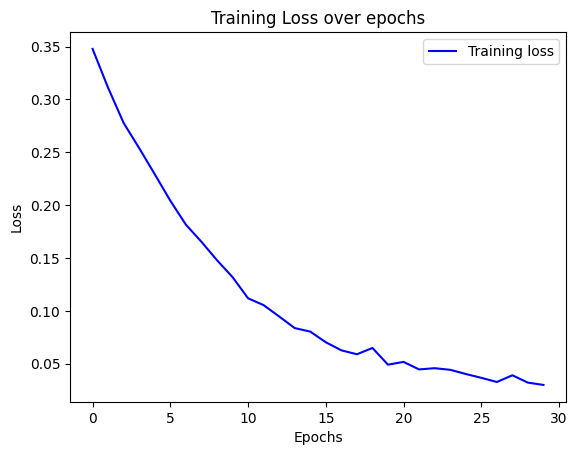

In [ ]:
plt.plot(train_losses,label = "Training loss",color="blue")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training Loss over epochs")
plt.legend()
plt.show()

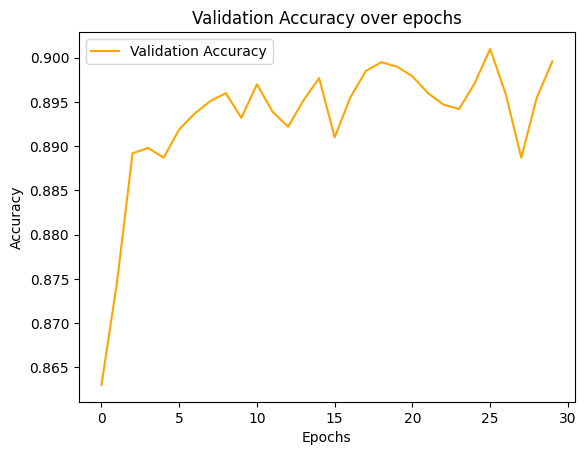

In [ ]:
plt.plot(val_accuracies, label='Validation Accuracy',color='orange')
plt.title('Validation Accuracy over epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()